----------------------
## IMPORTO LIBRERIE E CARICO FUNZIONI
-----------
-------------

LIBRERIE

In [4]:
import pandas as pd ## dataframes
import yfinance as yf ## for finance
import datetime as dt
import numpy as np ## linear algebra
np.random.seed(11) ## for reproducibility
import matplotlib.pyplot as plt
from scipy import stats ## main python statistical package
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import grangercausalitytests
from pandas.plotting import lag_plot
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import random
import datetime
from scipy.optimize import curve_fit
from scipy.stats import ttest_ind
from scipy.stats import kstest
from scipy.stats import linregress
from scipy.interpolate import interp1d


IMPORTO FUNZIONI

In [5]:
def diff(X_t, dt):
    N = len(X_t)
    diff_X_t = []
    for i in range(N):
        if i==0:
            diff = (X_t[i+1]-X_t[i])/dt
            diff_X_t.append(diff)
        
        elif i==N-1:
            diff = (X_t[i]-X_t[i-1])/dt
            diff_X_t.append(diff)
            
        else:
            diff_fw = (X_t[i+1]-X_t[i])/dt
            diff_bw = (X_t[i]-X_t[i-1])/dt
            diff = 0.5*(diff_fw+diff_bw)
            diff_X_t.append(diff)
    return diff_X_t
def CrossCorrelationAnalysis(X, Y, maxlag,dt,color1,color2,nome1,nome2,figname):
    """
    Perform the lagged-cross-correlation analysis between two time series X(t) and Y(t).
    X, Y are two 1-d numpy arrays.
    dt is the time step of the time series (default 1 a.u.) - it could be specified w.r.t a given unit
    """
    
    ### Make sure the two time series are stationary
    ### Performing for example the Augmented Dickey-Fuller Test
    from statsmodels.tsa.stattools import adfuller
    result_X, result_Y = adfuller(X), adfuller(Y)
    if (result_X[1] > 0.05 or result_Y[1]>0.05):
        print("Time Series are not stationary")
        return
    else:
        ## we consider X(t+lag), Y(t)
        ## so that for lag<0 X preceeds Y and vice-versa.
        dim = len(X)
        lags = np.arange(-maxlag, maxlag+1, 1)
        lagged_cross_corr = []
        for lag in lags:
            XY = [(X[t+lag], Y[t]) for t in range(dim-np.abs(lag))]
            X_lagged = [el[0] for el in XY]
            Y_lagged = [el[1] for el in XY]
            lagged_cross_corr.append(stats.pearsonr(X_lagged, Y_lagged)[0])
            
        #plt.figure(figsize=(3, 3), dpi=180)
        lags_min = [l for l in lags if l<=0]
        lags_maj = [l for l in lags if l>=0]
        lcc_min = [lagged_cross_corr[i] for i in range(len(lags)) if lags[i]<=0]
        lcc_maj = [lagged_cross_corr[i] for i in range(len(lags)) if lags[i]>=0]
        plt.plot(lags_min, lcc_min, lw=3, color=color1)
        plt.plot(lags_maj, lcc_maj, lw=3, color=color2)
        plt.vlines(0, -1, 1, lw=1, ls='--', color='k')
        plt.xlabel('lag temporali',fontsize='16'), plt.ylabel('lagged-cross-correlation',fontsize='16')
        plt.text(-100, 0.8, str(nome1)+' precede '+str(nome2), color=color1,fontsize='16')
        plt.text(5, 0.8, str(nome2)+' precede '+str(nome1), color=color2,fontsize='16')
        corr=lcc_min+lcc_maj
        lag = np.argmax(corr) - maxlag
        if(lag >= 1 ):lag = lag-1
        plt.savefig(str(figname)+'.svg')
        plt.show()
        print('lag = ',lag)
        print('max corr = ',max(lagged_cross_corr))
        
    return lagged_cross_corr   

def normalize(data):
    """
    Normalize a dataset using min-max normalization.
    
    Parameters:
    -----------
    data : pandas.DataFrame or numpy.ndarray
        The dataset to be normalized.
    
    Returns:
    --------
    pandas.DataFrame or numpy.ndarray
        The normalized dataset.
    """
    # compute min and max values for each feature
    min_vals = np.min(data, axis=-1)
    max_vals = np.max(data, axis=-1)
    
    # normalize each feature using min-max normalization
    normalized_data = (data - min_vals) / (max_vals - min_vals)
    
    # convert the result to a pandas.DataFrame if the input was a DataFrame
    if isinstance(data, pd.DataFrame):
        normalized_data = pd.DataFrame(normalized_data, columns=data.columns, index=data.index)
    
    return normalized_data
    
### 1. Check whether the two processes are stationary
### Two common tests are 
### A. Augmented Dickey-Fuller (ADF) Test
### B. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test


### ADF test is conducted with the following assumptions:
### Null Hypothesis (HO): Series is non-stationary, or series has a unit root.
### Alternate Hypothesis(HA): Series is stationary, or series has no unit root.
### If the null hypothesis is failed to be rejected, this test may provide evidence that the series is non-stationary.

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dfoutput[1] > 0.05:
        print("\n*** Time series is not stationary ***\n")
    else:
        print("\n*** Time series is stationary ***\n")

### The KPSS test is conducted with the following assumptions.
### Null Hypothesis (HO): Series is trend stationary or series has no unit root.
### Alternate Hypothesis(HA): Series is non-stationary, or series has a unit root.
### Note: The hypothesis is reversed in the KPSS test compared to ADF Test.
    
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    if kpss_output[1] < 0.05:
        print("\n*** Time series is not stationary ***\n")
    else:
        print("\n*** Time series is stationary ***\n") 


-----------------
## CARICO DATASETS
------------
----------

In [6]:
df1=pd.read_csv('co2_world.txt')
dt1=pd.read_csv('temp_glob')
df8=pd.read_csv('gas_serra.txt')
dt8=pd.read_csv('Dati_800kY.txt')

SISTEMO

In [7]:
variaz_CO2_8=df8['CO2']-df8['CO2'].mean()
variaz_temp_8_raw=dt8['Temperature']-dt8['Temperature'].mean()
appoggio = df1.groupby('Year')['Emission_CO2'].mean() 
appoggio2 = appoggio.reset_index()
appoggio_selezionate = appoggio2.loc[(appoggio2['Year'] >= 1900) & (appoggio2['Year'] <= 2017)]
emissioni_per_anno = appoggio_selezionate['Emission_CO2'].reset_index(drop=True)-1.5
temp_1=dt1['TEMP']-2.8
arr_sorted = np.sort(variaz_temp_8_raw)
temp_interp = interp1d((dt8['Age'][1:])/1000, dt8['Temperature'][1:])(df8['Age'][1:])
variaz_temp_8a=temp_interp-dt8['Temperature'].mean()
variaz_temp_8=pd.Series(variaz_temp_8a)
variaz_CO2_8=variaz_CO2_8[0:4000]

PLOT DATA


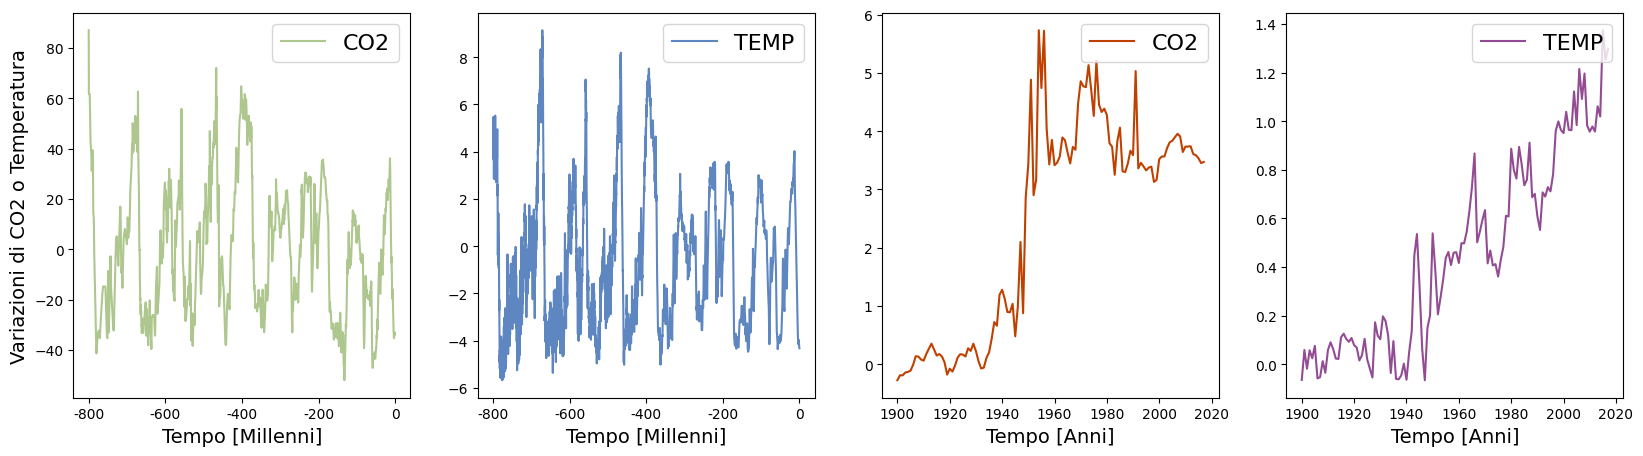

In [8]:
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(20,5))
etichette = ['1900', '1920', '1940','1960', '1980', '2000']
years = np.array([-800, -600, -400, -200, 0])
indices = np.linspace(-4000,0, len(years))
ax[0].plot(list(range(-4000, 0)),variaz_CO2_8,color='#9AB973',label='CO2',alpha=0.8)
#ax[0].plot(anni,stm.rolling(60, center=True,win_type='hamming').mean(),color='black',lw=2)
ax[0].set_xlabel('Tempo [Millenni]',fontsize='14')
ax[0].set_ylabel('Variazioni di CO2 o Temperatura',fontsize='14')
ax[0].set_xticks(indices,years)
ax[1].plot(list(range(-4000, 0)),variaz_temp_8,color='#5E86C1',label='TEMP')
ax[1].set_xlabel('Tempo [Millenni]',fontsize='14')
ax[1].set_xticks(indices,years)
#ax[1].plot(anni,tsmc.rolling(60, center=True,win_type='hamming').mean(),color='black',lw=2)
ax[2].plot(list(range(1900, 2018)),emissioni_per_anno,color='#C04000',label='CO2')
ax[2].set_xlabel('Tempo [Anni]',fontsize='14')
#ax[2].plot(anni,race.rolling(60, center=True,win_type='hamming').mean(),color='black',lw=2)
ax[3].plot(list(range(1900, 2018)),temp_1,color='#660066',label='TEMP',alpha=0.7)
ax[3].set_xlabel('Tempo [Anni]',fontsize='14')
#ax[3].plot(anni,SeP500.rolling(60, center=True,win_type='hamming').mean(),color='black',lw=2)
ax[0].legend(fontsize='16',loc='upper right'),ax[1].legend(fontsize='16',loc='upper right'),ax[2].legend(fontsize='16',loc='upper right'),ax[3].legend(fontsize='16',loc='upper right')
plt.savefig('grafici.svg')

----------------
STUDIO DISTRIBUZIONE DEI DATI TRAMITE MODELLI NULLI
---------
-----------

t-statistic = 0.463944774417621
p-value = 0.6427017434912309
t-statistic = -11.060977208836201
p-value = 2.944399043909485e-24
t-statistic = -11.104113331494991
p-value = 2.081125993143035e-24
t-statistic = -0.2916424180993618
p-value = 0.7705686839680121


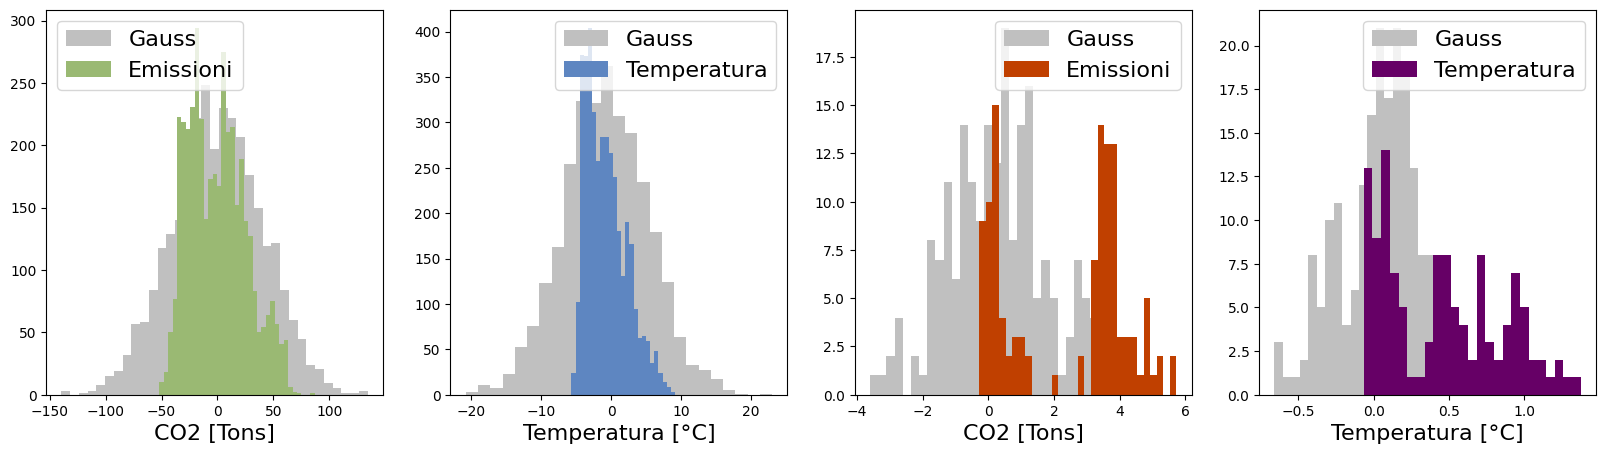

In [9]:
fig, fg = plt.subplots(ncols=4,figsize=(20,5))

gaussb=np.random.normal(variaz_CO2_8.mean(),40,3000)
fg[0].hist(gaussb,bins=35,color='#C0C0C0',label='Gauss')
fg[0].hist(variaz_CO2_8,bins=35,color='#9AB973',label='Emissioni')
fg[0].set_xlabel('CO2 [Tons]',fontsize='16')
t_stat, p_val = ttest_ind(gaussb, variaz_CO2_8)
print("t-statistic =", t_stat)
print("p-value =", p_val)
fg[0].legend(loc='upper left',fontsize='16')

gaussd=np.random.normal(temp_1.head(40).mean(),0.25,200)
fg[3].hist(gaussd,bins=25,color='#C0C0C0',label='Gauss')
fg[3].hist(temp_1,bins=25,color='#660066',label='Temperatura')
fg[3].set_xlabel('Temperatura [°C]',fontsize='16')
t_stat, p_val = ttest_ind(gaussd, temp_1)
print("t-statistic =", t_stat)
print("p-value =", p_val)
fg[3].legend(fontsize='16')

gaussc=np.random.normal(emissioni_per_anno.head(40).mean(),1.5,200)
fg[2].hist(gaussc,bins=30,color='#C0C0C0',label='Gauss')
fg[2].hist(emissioni_per_anno,bins=30,color='#C04000',label='Emissioni')
fg[2].set_xlabel('CO2 [Tons]',fontsize='16')
t_stat, p_val = ttest_ind(gaussc, emissioni_per_anno)
print("t-statistic =", t_stat)
print("p-value =", p_val)
fg[2].legend(fontsize='16')

gausse=np.random.normal(variaz_temp_8.mean(),6,3000)
fg[1].hist(gausse,bins=25,color='#C0C0C0',label='Gauss')
fg[1].hist(variaz_temp_8,bins=25,color='#5E86C1',label='Temperatura')
fg[1].set_xlabel('Temperatura [°C]',fontsize='16')
t_stat, p_val = ttest_ind(gausse, variaz_temp_8)
print("t-statistic =", t_stat)
print("p-value =", p_val)
fg[1].legend(fontsize='16')

plt.savefig('hist.svg',format='svg')
plt.show()

-------------
## DETRENDING
------
----------

DIFFERENZIO

In [10]:
d_co2_1l = diff(emissioni_per_anno,1)
d_temp_1l = diff(temp_1,1)
d_temp_8l = diff(variaz_temp_8,1)
d_co2_8l = diff(variaz_CO2_8,1)



NORMALIZZO E FACCIO MEDIO

In [11]:
d_co2_1l = normalize(d_co2_1l)
d_temp_1l = normalize(d_temp_1l)
d_co2_8l = normalize (d_co2_8l)
d_temp_8l = normalize (d_temp_8l)

d_co2_1s = pd.Series(d_co2_1l)
d_temp_1s = pd.Series(d_temp_1l)
d_co2_8s = pd.Series(d_co2_8l)
d_temp_8s = pd.Series(d_temp_8l)

d_co2_1s=d_co2_1s-d_co2_1s.mean()
d_temp_1s=d_temp_1s-d_temp_1s.mean()
d_co2_8s=d_co2_8s-d_co2_8s.mean()
d_temp_8s=d_temp_8s-d_temp_8s.mean()

d_co2_1=d_co2_1s.tolist()
d_temp_1=d_temp_1s.tolist()
d_co2_8=d_co2_8s.tolist()
d_temp_8=d_temp_8s.tolist()



PLOT DETRENDING

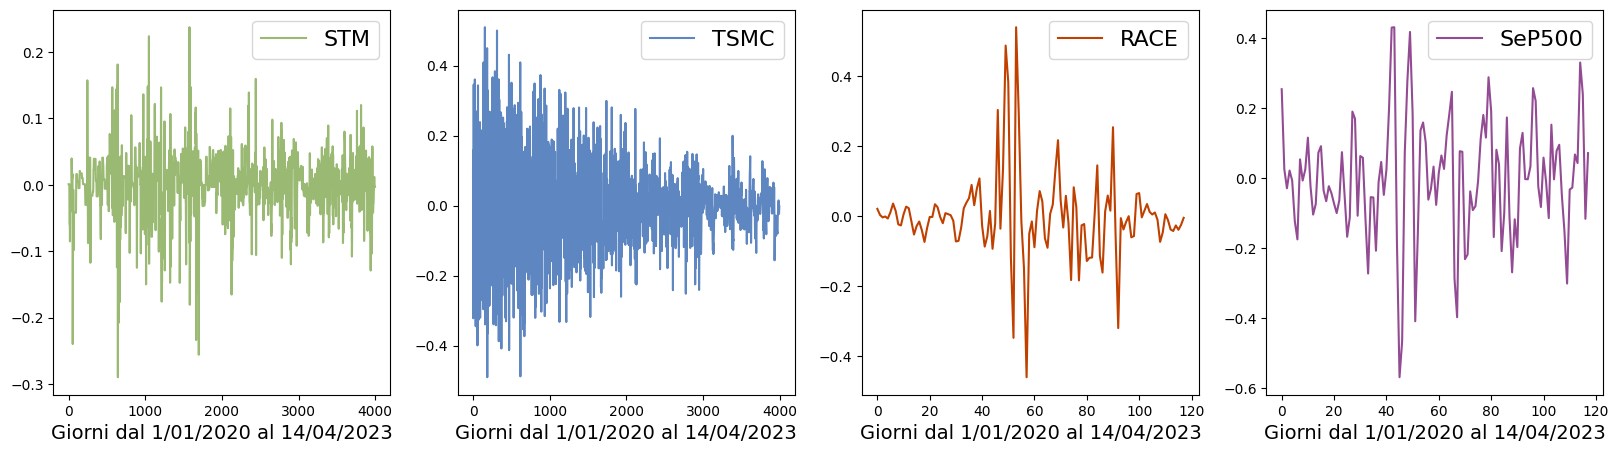

In [12]:
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(20,5))
ax[0].plot(d_co2_8[3:],color='#9AB973',label='STM')
ax[0].set_xlabel('Giorni dal 1/01/2020 al 14/04/2023',fontsize='14')
ax[1].plot(d_temp_8[3:],color='#5E86C1',label='TSMC')
ax[1].set_xlabel('Giorni dal 1/01/2020 al 14/04/2023',fontsize='14')
ax[2].plot(d_co2_1,color='#C04000',label='RACE')
ax[2].set_xlabel('Giorni dal 1/01/2020 al 14/04/2023',fontsize='14')
ax[3].plot(d_temp_1,color='#660066',label='SeP500',alpha=0.7)
ax[3].set_xlabel('Giorni dal 1/01/2020 al 14/04/2023',fontsize='14')
ax[0].legend(fontsize='16',loc='upper right'),ax[1].legend(fontsize='16',loc='upper right'),ax[2].legend(fontsize='16',loc='upper right'),ax[3].legend(fontsize='16',loc='upper right')
plt.savefig('grafici1.svg')

TESTO STAZIONARIETA' CON ADF E KPSS TEST

In [13]:
print('---------------------')
print('STAZIONARIETA\' STM :')
print('---------------------')
adf_test(variaz_CO2_8)
kpss_test(variaz_CO2_8)
print('----------------------')
print('STAZIONARIETA\' TSMC :')
print('----------------------')
adf_test(variaz_temp_8)
kpss_test(variaz_temp_8)
print('----------------------')
print('STAZIONARIETA\' RACE :')
print('----------------------')
adf_test(d_co2_1)
kpss_test(d_co2_1)
print('------------------------')
print('STAZIONARIETA\' SeP500 :')
print('------------------------')
adf_test(d_temp_1)
kpss_test(d_temp_1)

---------------------
STAZIONARIETA' STM :
---------------------
Results of Dickey-Fuller Test:
Test Statistic                   -4.567080
p-value                           0.000148
#Lags Used                       24.000000
Number of Observations Used    3975.000000
Critical Value (1%)              -3.431996
Critical Value (5%)              -2.862267
Critical Value (10%)             -2.567157
dtype: float64

*** Time series is stationary ***

Results of KPSS Test:
Test Statistic            0.299503
p-value                   0.100000
#Lags Used               39.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

*** Time series is stationary ***

----------------------
STAZIONARIETA' TSMC :
----------------------
Results of Dickey-Fuller Test:
Test Statistic                   -5.470435
p-value                           0.000002
#Lags Used                       26.000000
Number

--------------
## CROSS CORRELATION
----------
-----------

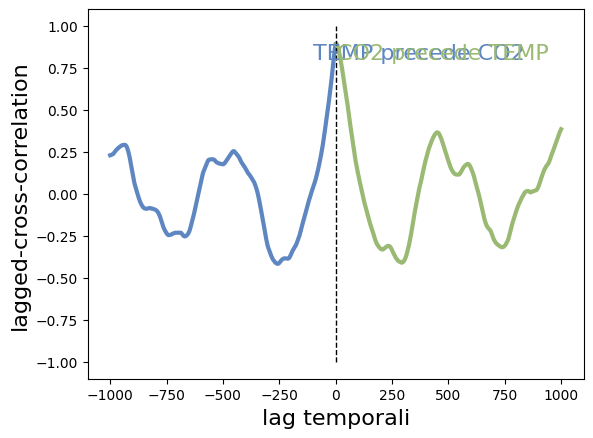

lag =  3
max corr =  0.8954327640650951


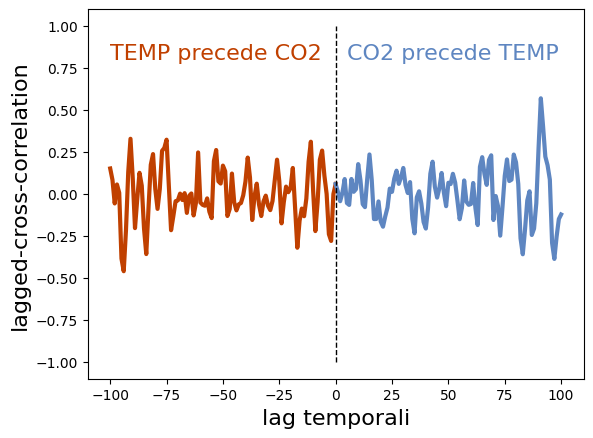

lag =  91
max corr =  0.5691711108872626


In [14]:
lag=1000
corr1 = CrossCorrelationAnalysis(variaz_temp_8.tolist(),variaz_CO2_8.tolist(), lag,1,color1='#5E86C1',color2='#9AB973',nome1='TEMP',nome2='CO2',figname='corr1')
#corr2 = CrossCorrelationAnalysis(d_temp_8,d_co2_8, lag,1,color1='#9AB973',color2='#C04000',nome1='TEMP',nome2='CO2',figname='corr2')
lag=100
corr3 = CrossCorrelationAnalysis(d_temp_1,d_co2_1, lag,1,color1='#C04000',color2='#5E86C1',nome1='TEMP',nome2='CO2',figname='corr3')


---------------------
## SHUFFLE DATI E CROSS CORRELATION

--------------


In [15]:
import random

def shuffle_copy(arr):
    arr_copy = arr.copy()
    random.shuffle(arr_copy)
    return arr_copy


In [16]:
variaz_CO2_8_shuffle=shuffle_copy(variaz_CO2_8)
variaz_temp_8_shuffle=shuffle_copy(variaz_temp_8)
d_co2_8_shuffle = shuffle_copy(d_co2_8)
d_temp_8_shuffle = shuffle_copy(d_temp_8)
d_co2_1_shuffle = shuffle_copy(d_co2_1)
d_temp_1_shuffle = shuffle_copy(d_temp_1)


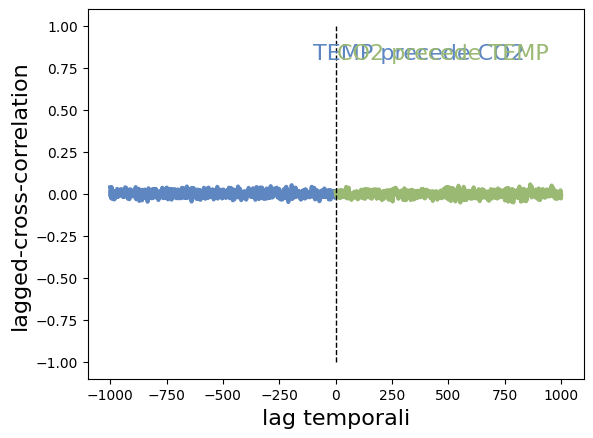

lag =  863
max corr =  0.05669297064408185


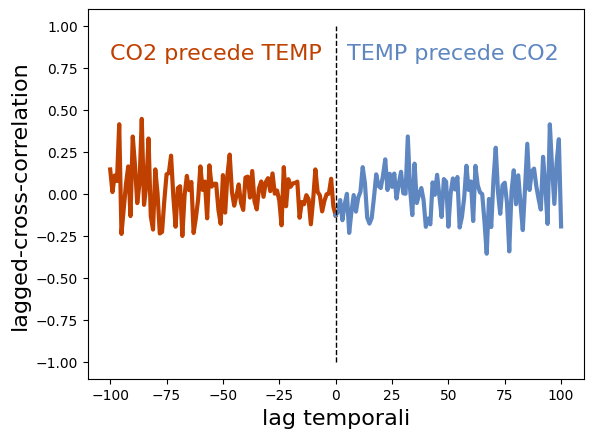

lag =  -86
max corr =  0.4466749119793565


In [29]:
lag=1000
corr1 = CrossCorrelationAnalysis(variaz_CO2_8_shuffle.tolist(),variaz_temp_8_shuffle.tolist(), lag,1,color1='#5E86C1',color2='#9AB973',nome1='TEMP',nome2='CO2',figname='corr1_shuffle')
#corr2 = CrossCorrelationAnalysis(d_co2_8_shuffle,d_temp_8_shuffle, lag,1,color1='#9AB973',color2='#C04000',nome1='CO2',nome2='TEMP',figname='corr2_shuffle')
lag=100
corr3 = CrossCorrelationAnalysis(d_co2_1_shuffle,d_temp_1_shuffle, lag,1,color1='#C04000',color2='#5E86C1',nome1='CO2',nome2='TEMP',figname='corr3_shuffle')

----------------
## GRANGER CAUSALITY
------------
------------

TROVO I LAG OTTIMALI 

-----------------

In [18]:
def splitter(data_df):
    end = round(len(data_df)*.8)
    train_df = data_df[:end]
    test_df = data_df[end:]
    return train_df, test_df

def select_p(train_df):
    aic, bic, fpe, hqic = [], [], [], []
    model = VAR(train_df) 
    p = np.arange(1,50)
    for i in p:
        result = model.fit(i)
        aic.append(result.aic)
        bic.append(result.bic)
        fpe.append(result.fpe)
        hqic.append(result.hqic)
    lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                    'BIC': bic, 
                                    'HQIC': hqic,
                                    'FPE': fpe}, 
                                   index=p)    
    fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
    lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
    plt.tight_layout()
    print(lags_metrics_df.idxmin(axis=0))

AIC     31
BIC     31
HQIC    31
FPE     43
dtype: int64


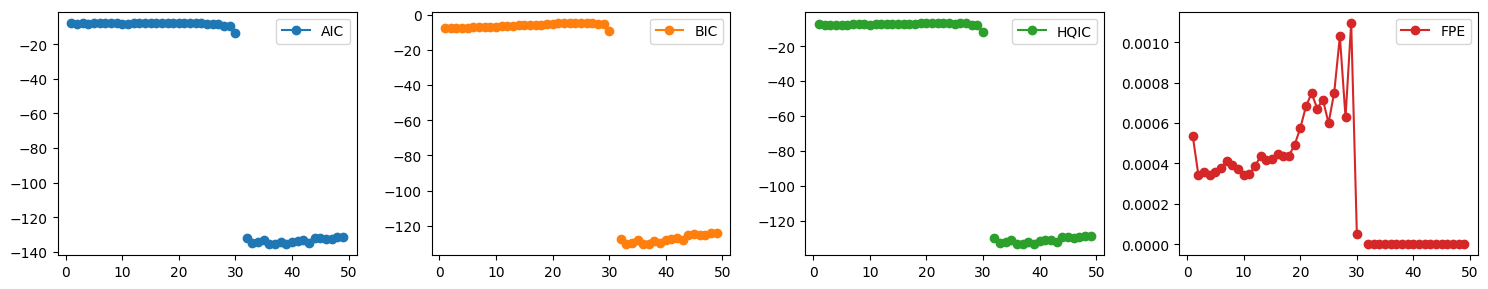

In [19]:
data=pd.concat([pd.Series(d_co2_1),pd.Series(d_temp_1)], axis=1)
train_df, test_df = splitter(data)
select_p(train_df)
#plt.savefig('aicbic_stm_tsmc.svg')

AIC     41
BIC      4
HQIC     6
FPE     41
dtype: int64


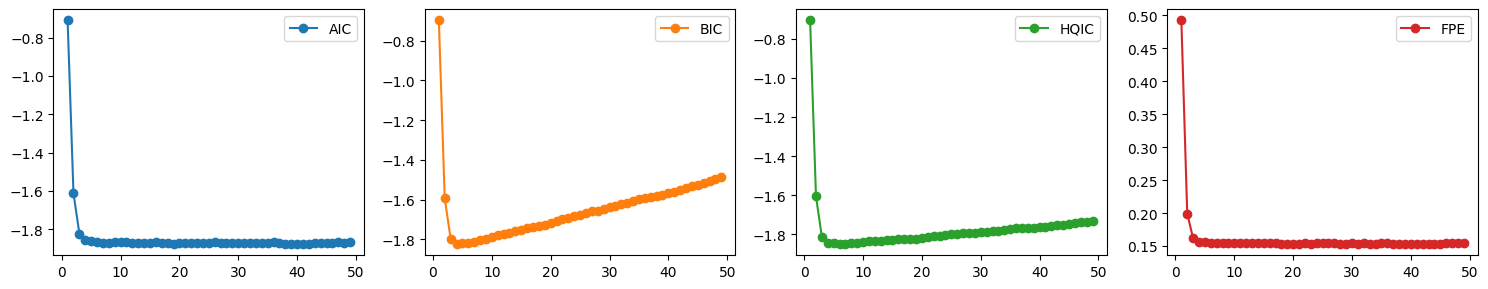

In [20]:
data=pd.concat([pd.Series(variaz_CO2_8),pd.Series(variaz_temp_8)], axis=1)
train_df, test_df = splitter(data)
select_p(train_df)
#plt.savefig('aicbic_stm_race.svg')

AIC     46
BIC     14
HQIC    32
FPE     46
dtype: int64


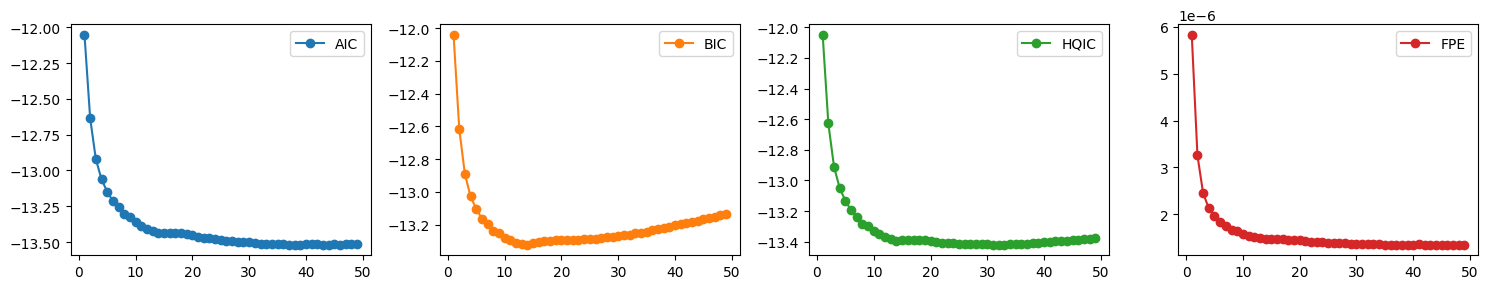

In [21]:
data=pd.concat([pd.Series(d_co2_8),pd.Series(d_temp_8)], axis=1)
train_df, test_df = splitter(data)
select_p(train_df)
#plt.savefig('aicbic_race_tsmc.svg')

---------------
GC:  TEMP_1 -> CO2_1

--------------------

In [22]:
maxlag=[31]
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_co2_1,'column2': d_temp_1})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')



Lag: 31
Granger causality p-value: 0.19132303289783129


---------------
GC:  CO2_1 -> TEMP_1

--------------------

In [23]:
maxlag=[31]
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_temp_1,'column2': d_co2_1})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')

Lag: 31
Granger causality p-value: 0.12297883881974121


---------------
GC:  CO2_8-> TEMP_8

--------------------

In [24]:
maxlag=[4]
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': variaz_temp_8,'column2': variaz_CO2_8})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')



Lag: 4
Granger causality p-value: 3.233648266865581e-48


---------------
GC:  TEMP->CO2

--------------------

In [25]:
maxlag=[4]
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': variaz_CO2_8,'column2': variaz_temp_8})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')


Lag: 4
Granger causality p-value: 9.721805844900382e-14


------------------------
## CONTROLLO I RESIDUI PER AUTOCORRELAZIONE
------------------
-----------------------

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 03, Jun, 2023
Time:                     00:44:15
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -2.08058
Nobs:                     3996.00    HQIC:                  -2.09888
Log likelihood:          -7108.51    FPE:                   0.121368
AIC:                     -2.10893    Det(Omega_mle):        0.120823
--------------------------------------------------------------------
Results for equation column1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             -0.034804         0.007291           -4.774           0.000
L1.column1         0.772199         0.015865           48.674           0.000
L1.column2         0.054901         0.007090            7.743         

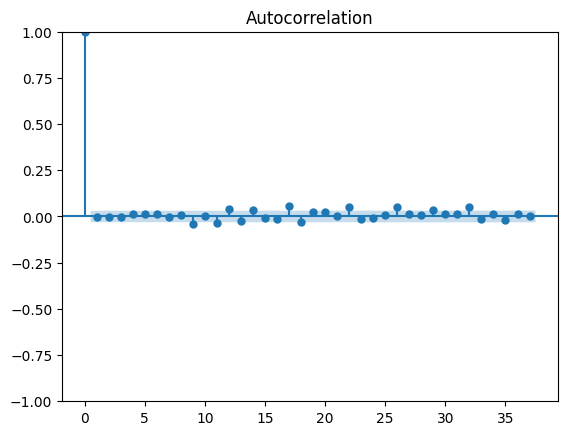

In [26]:
# Esegui l'analisi causale utilizzando modelli VAR
data = pd.DataFrame({'column1': variaz_temp_8,'column2': variaz_CO2_8})
model = sm.tsa.VAR(data)
results = model.fit(maxlags=4, ic='aic')
print(results.summary())
residuals = results.resid['column1']
plot_acf(residuals)

df=data
model = sm.tsa.VAR(df)
results = model.fit(maxlags=20, ic='aic')
residuals = results.resid
#test residui per normalità
#Questa funzione esegue il test di Ljung-Box sui residui. Il parametro "lags" specifica il numero di ritardi da includere nel test.
print('jung-box =')
print(sm.stats.acorr_ljungbox(residuals['column1'], lags=20))

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 03, Jun, 2023
Time:                     00:44:16
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.95437
Nobs:                     116.000    HQIC:                  -8.09539
Log likelihood:           155.928    FPE:                0.000276958
AIC:                     -8.19175    Det(Omega_mle):     0.000254541
--------------------------------------------------------------------
Results for equation column1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.000198         0.010443            0.019           0.985
L1.column1         0.299576         0.086095            3.480           0.001
L1.column2         0.073649         0.066746            1.103         

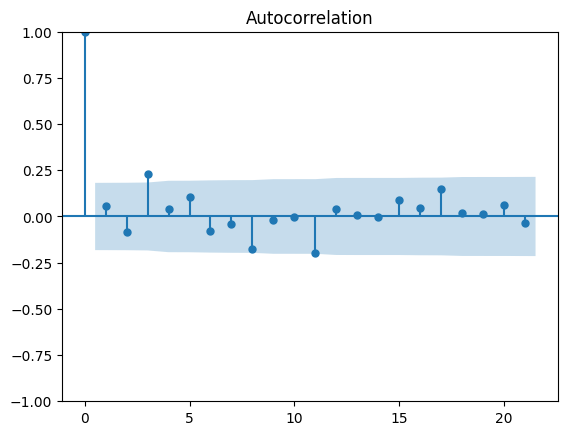

In [27]:
# Esegui l'analisi causale utilizzando modelli VAR
data = pd.DataFrame({'column1': d_co2_1,'column2': d_temp_1})
model = sm.tsa.VAR(data)
results = model.fit(maxlags=4, ic='aic')
print(results.summary())
residuals = results.resid['column1']
plot_acf(residuals)

df=data
model = sm.tsa.VAR(df)
results = model.fit(maxlags=20, ic='aic')
residuals = results.resid
#test residui per normalità
#Questa funzione esegue il test di Ljung-Box sui residui. Il parametro "lags" specifica il numero di ritardi da includere nel test.
print('jung-box =')
print(sm.stats.acorr_ljungbox(residuals['column1'], lags=20))